In [3]:
%matplotlib inline
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from p2ch14.dsets import getCandidateInfoList, getCt, LunaDataset
# The code is not compatiable with p2ch14.vis!
from p2ch12.vis import findPositiveSamples, showCandidate
from util.util import xyz2irc

In [4]:
candidateInfo_list = getCandidateInfoList(requireOnDisk_bool=False)
positiveSample_list = findPositiveSamples()

2025-05-26 11:51:11,624 INFO     pid:14824 p2ch12.dsets:266:__init__ <p2ch12.dsets.LunaDataset object at 0x000001570B48A7B0>: 551065 training samples, 549714 neg, 1351 pos, unbalanced ratio


0 CandidateInfoTuple(isNodule_bool=True, diameter_mm=32.27003025, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886', center_xyz=(67.61451718, 85.02525992, -109.8084416))
1 CandidateInfoTuple(isNodule_bool=True, diameter_mm=30.61040636, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.112740418331256326754121315800', center_xyz=(47.90350511, 37.60442008, -99.93417567))
2 CandidateInfoTuple(isNodule_bool=True, diameter_mm=30.61040636, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.112740418331256326754121315800', center_xyz=(44.19, 37.79, -107.01))
3 CandidateInfoTuple(isNodule_bool=True, diameter_mm=30.61040636, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.112740418331256326754121315800', center_xyz=(40.69, 32.19, -97.15))
4 CandidateInfoTuple(isNodule_bool=True, diameter_mm=27.44242293, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.943403138251347598519939390311', center_xyz=(-45.29440163, 74.86925386, -97.52812481))
5 CandidateInfoTuple(isNodule_bool=True, dia

In [5]:
augmentation_dict = {}
augmentation_list = [
    ('None', {}),
    ('flip', {'flip': True}),
    ('offset', {'offset': 0.1}),
    ('scale', {'scale': 0.2}),
    ('rotate', {'rotate': True}),
    ('noise', {'noise': 25.0}),    
]
ds_list = [
    LunaDataset(sortby_str='series_uid', augmentation_dict=augmentation_dict) 
    for title_str, augmentation_dict in augmentation_list
]

2025-05-26 11:51:15,596 INFO     pid:14824 p2ch14.dsets:312:__init__   flip  : True
2025-05-26 11:51:15,884 INFO     pid:14824 p2ch14.dsets:312:__init__   offset: 0.1
2025-05-26 11:51:16,175 INFO     pid:14824 p2ch14.dsets:312:__init__   scale : 0.2
2025-05-26 11:51:16,463 INFO     pid:14824 p2ch14.dsets:312:__init__   rotate: True
2025-05-26 11:51:16,744 INFO     pid:14824 p2ch14.dsets:312:__init__   noise : 25.0


In [8]:
all_dict = {}
for title_str, augmentation_dict in augmentation_list:
    all_dict.update(augmentation_dict) # Add the key-value pair from the source dict by copying
all_ds = LunaDataset(sortby_str='series_uid', augmentation_dict=all_dict)
print(all_dict)

2025-05-26 11:51:38,099 INFO     pid:14824 p2ch14.dsets:312:__init__   flip  : True
2025-05-26 11:51:38,101 INFO     pid:14824 p2ch14.dsets:312:__init__   noise : 25.0
2025-05-26 11:51:38,101 INFO     pid:14824 p2ch14.dsets:312:__init__   offset: 0.1
2025-05-26 11:51:38,102 INFO     pid:14824 p2ch14.dsets:312:__init__   rotate: True
2025-05-26 11:51:38,103 INFO     pid:14824 p2ch14.dsets:312:__init__   scale : 0.2


{'flip': True, 'offset': 0.1, 'scale': 0.2, 'rotate': True, 'noise': 25.0}


The global variable `augmentation_dict` is resued in the for loop in `for title_str, augmentation_dict in augmentation_list:`. In Python, loop variables leak into the outer scope. They’re not confined to a local block (unlike languages like C++ or Java). This is why `augmentation_dict`. So at the end of the loop, `augmentation_dict` holds the last dictionary in the original `augmentation_list`.

In [9]:
augmentation_dict

{'noise': 25.0}

The method `list.extend(iterable)` adds each element from the iterable to the end of the list. The `*3` duplicates the tuple 3 times into a list:

In [10]:
augmentation_list.extend([('All', augmentation_dict)] * 3)
ds_list.extend([all_ds] * 3)

In [12]:
augmentation_list

[('None', {}),
 ('flip', {'flip': True}),
 ('offset', {'offset': 0.1}),
 ('scale', {'scale': 0.2}),
 ('rotate', {'rotate': True}),
 ('noise', {'noise': 25.0}),
 ('All', {'noise': 25.0}),
 ('All', {'noise': 25.0}),
 ('All', {'noise': 25.0})]

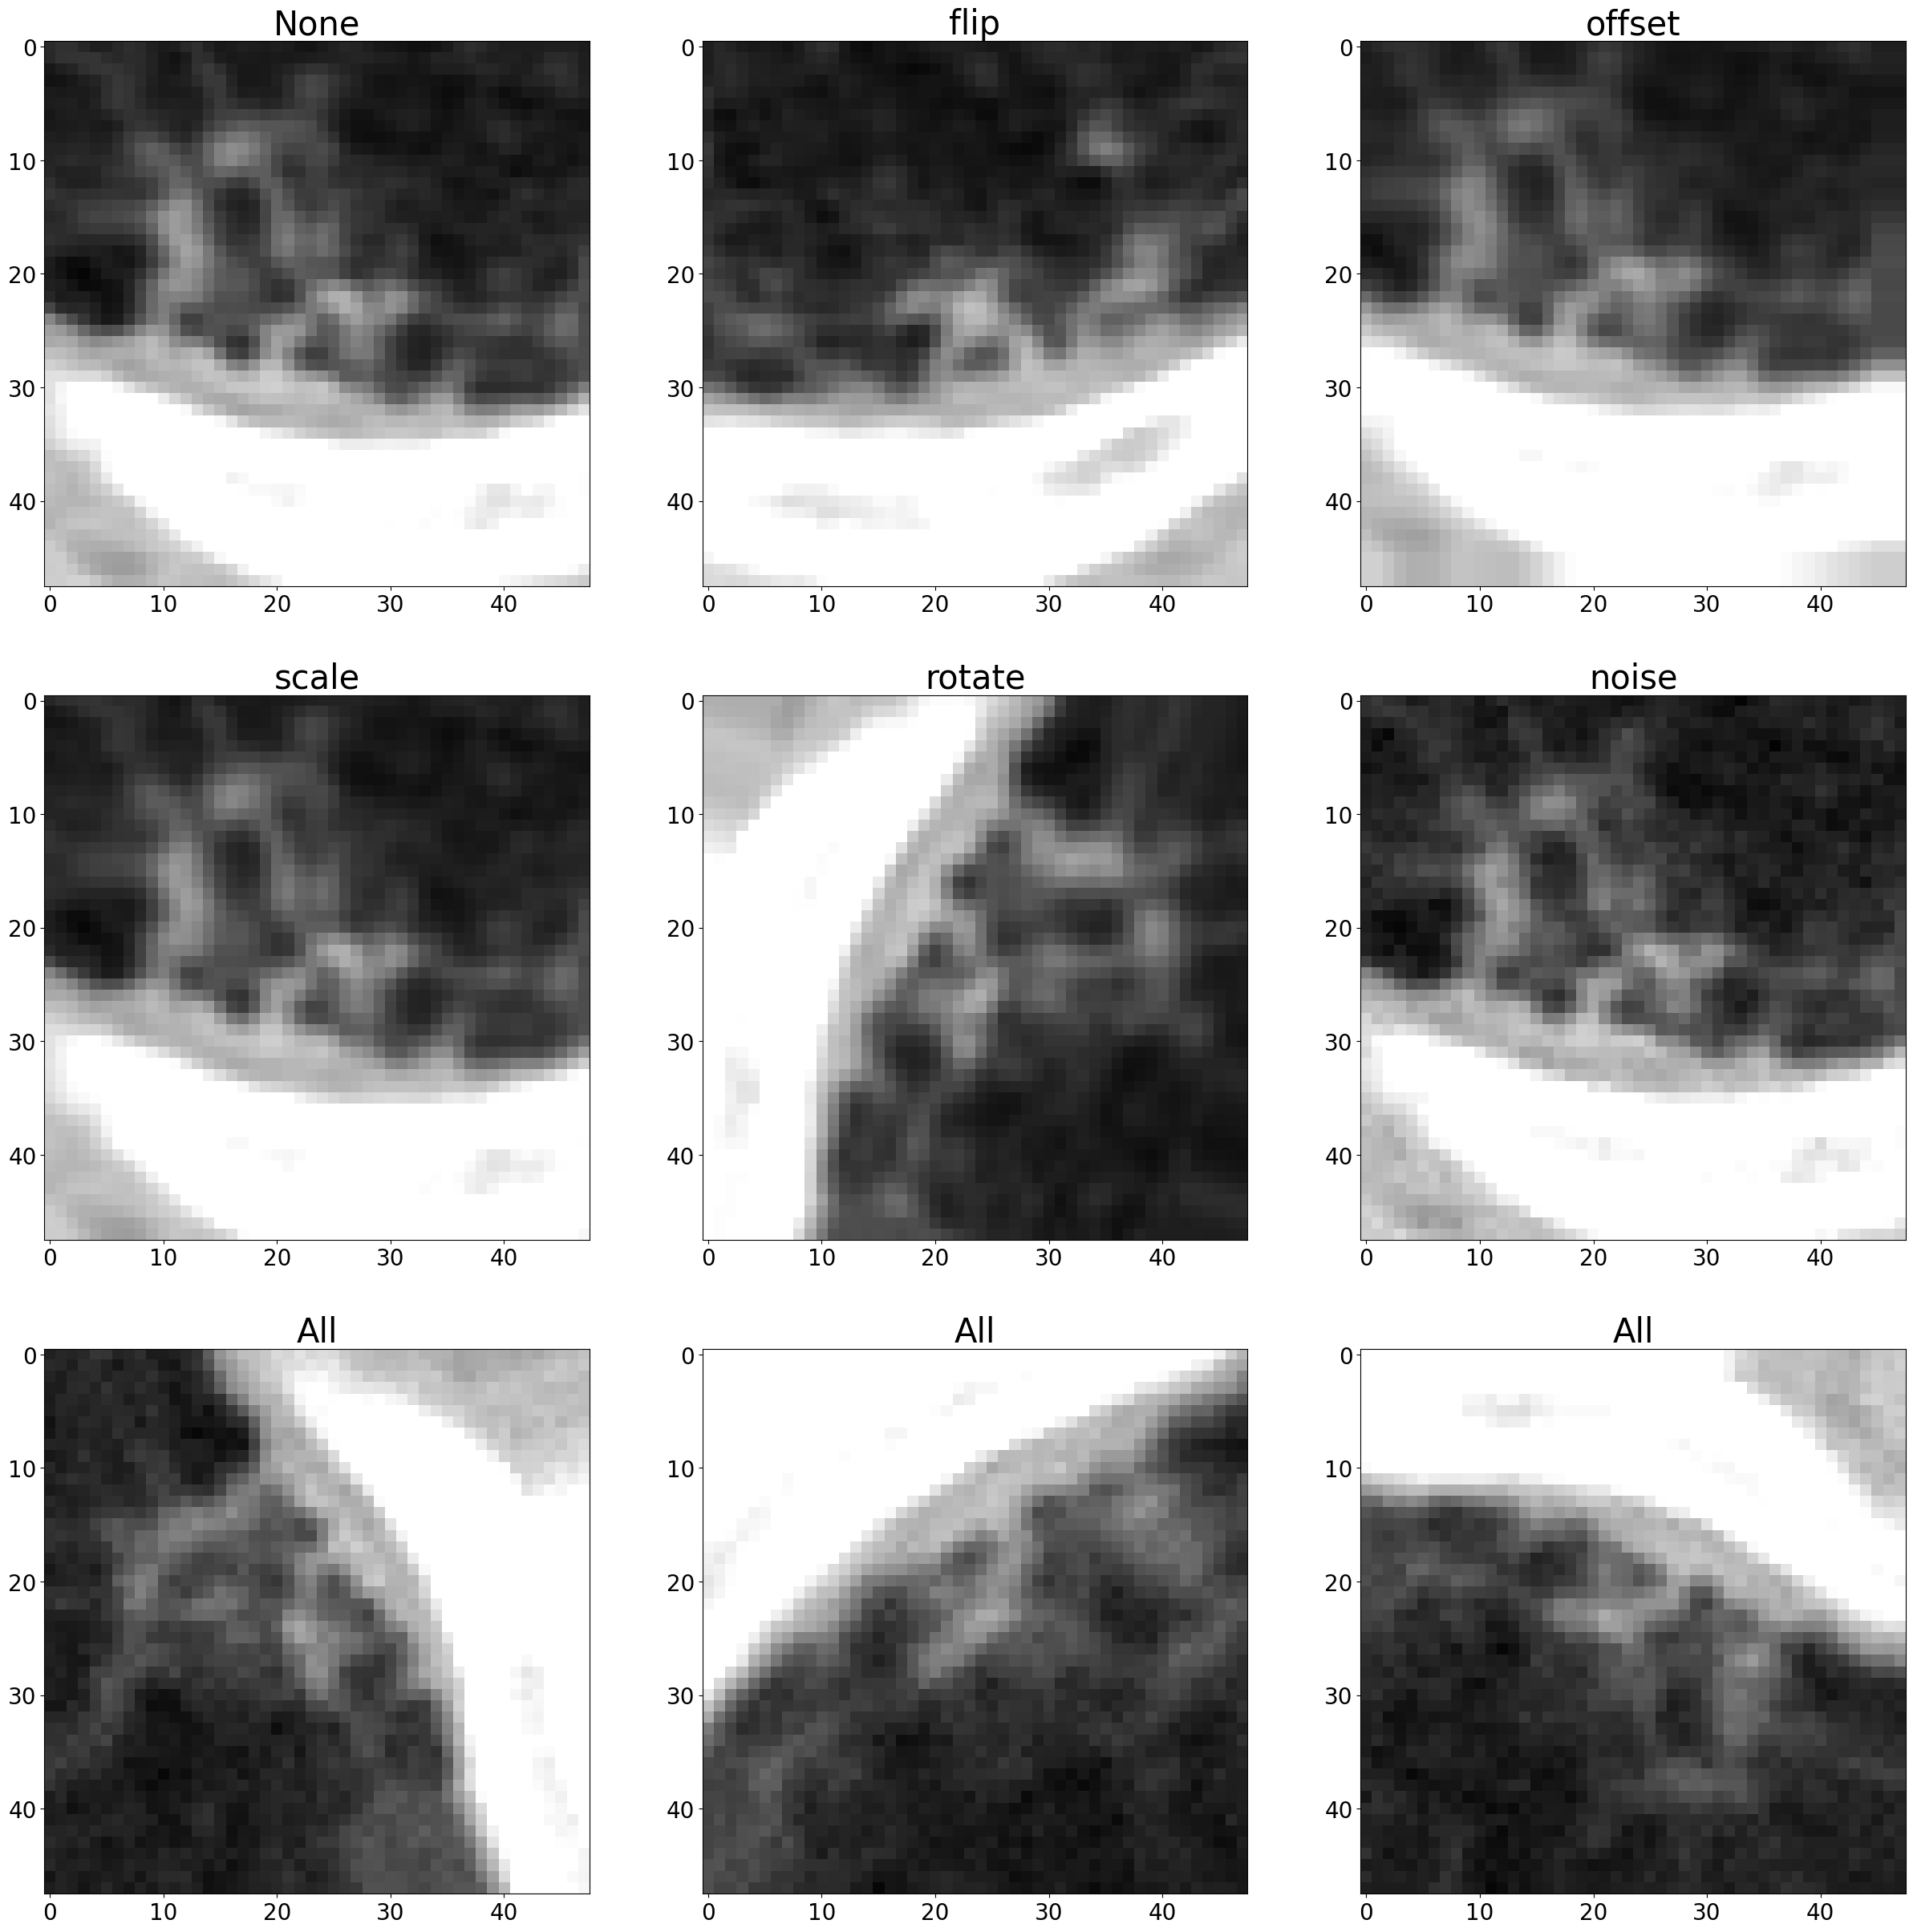

In [13]:
sample_index = 155
figure = plt.figure(figsize=(30, 30))
window_range = (-1000.0, 300)

# Iterate over augmentation settings and their corresponding datasets
for i, (augmentation_info, dataset) in enumerate(zip(augmentation_list, ds_list)):
    # Get the augmentation name (e.g., "flip", "rotate")
    title_str = augmentation_info[0]

    # Get the sample from the dataset
    # Unpack the sample: (candidate_tensor, label_tensor, series_uid, center_irc_tensor)
    # candidate_tensor is a 4D tensor (1, 32, 48, 48) representing a 3D CT chunk with 1 channel.
    candidate_tensor = dataset[sample_index][0]

    # Extract the middle slice (i.e., index = 16)
    # candidate_tensor[0] indexes the first (and only) channel.
    # candidate_tensor[0][16] indexes the 17th slice (index 16) along the depth axis.
    middle_slice = candidate_tensor[0][16]

    # .add_subplot(nrows, ncols, index) divides the figure into a grid of nrows × ncols, then
    # places a new subplot at position index (starting from 1, left to right, top to bottom)."
    subplot = figure.add_subplot(3, 3, i + 1)
    subplot.set_title(title_str, fontsize=30)
    
    # Change the font size of the axis tick labels along both x and y axes on a matplotlib subplot.
    # .get_xticklabels() return a list of Text objects that are the labels along the X-axis (horizontal axis) ticks.
    # The sum creates one combined list of all tick labels — both X and Y — so you can update them in a single loop.
    for label in subplot.get_xticklabels() + subplot.get_yticklabels():
        label.set_fontsize(20)

    plt.imshow(middle_slice, clim=window_range, cmap='gray')


2025-05-26 11:52:08,164 INFO     pid:14824 p2ch12.dsets:266:__init__ <p2ch12.dsets.LunaDataset object at 0x00000157317951D0>: 911 training samples, 904 neg, 7 pos, unbalanced ratio


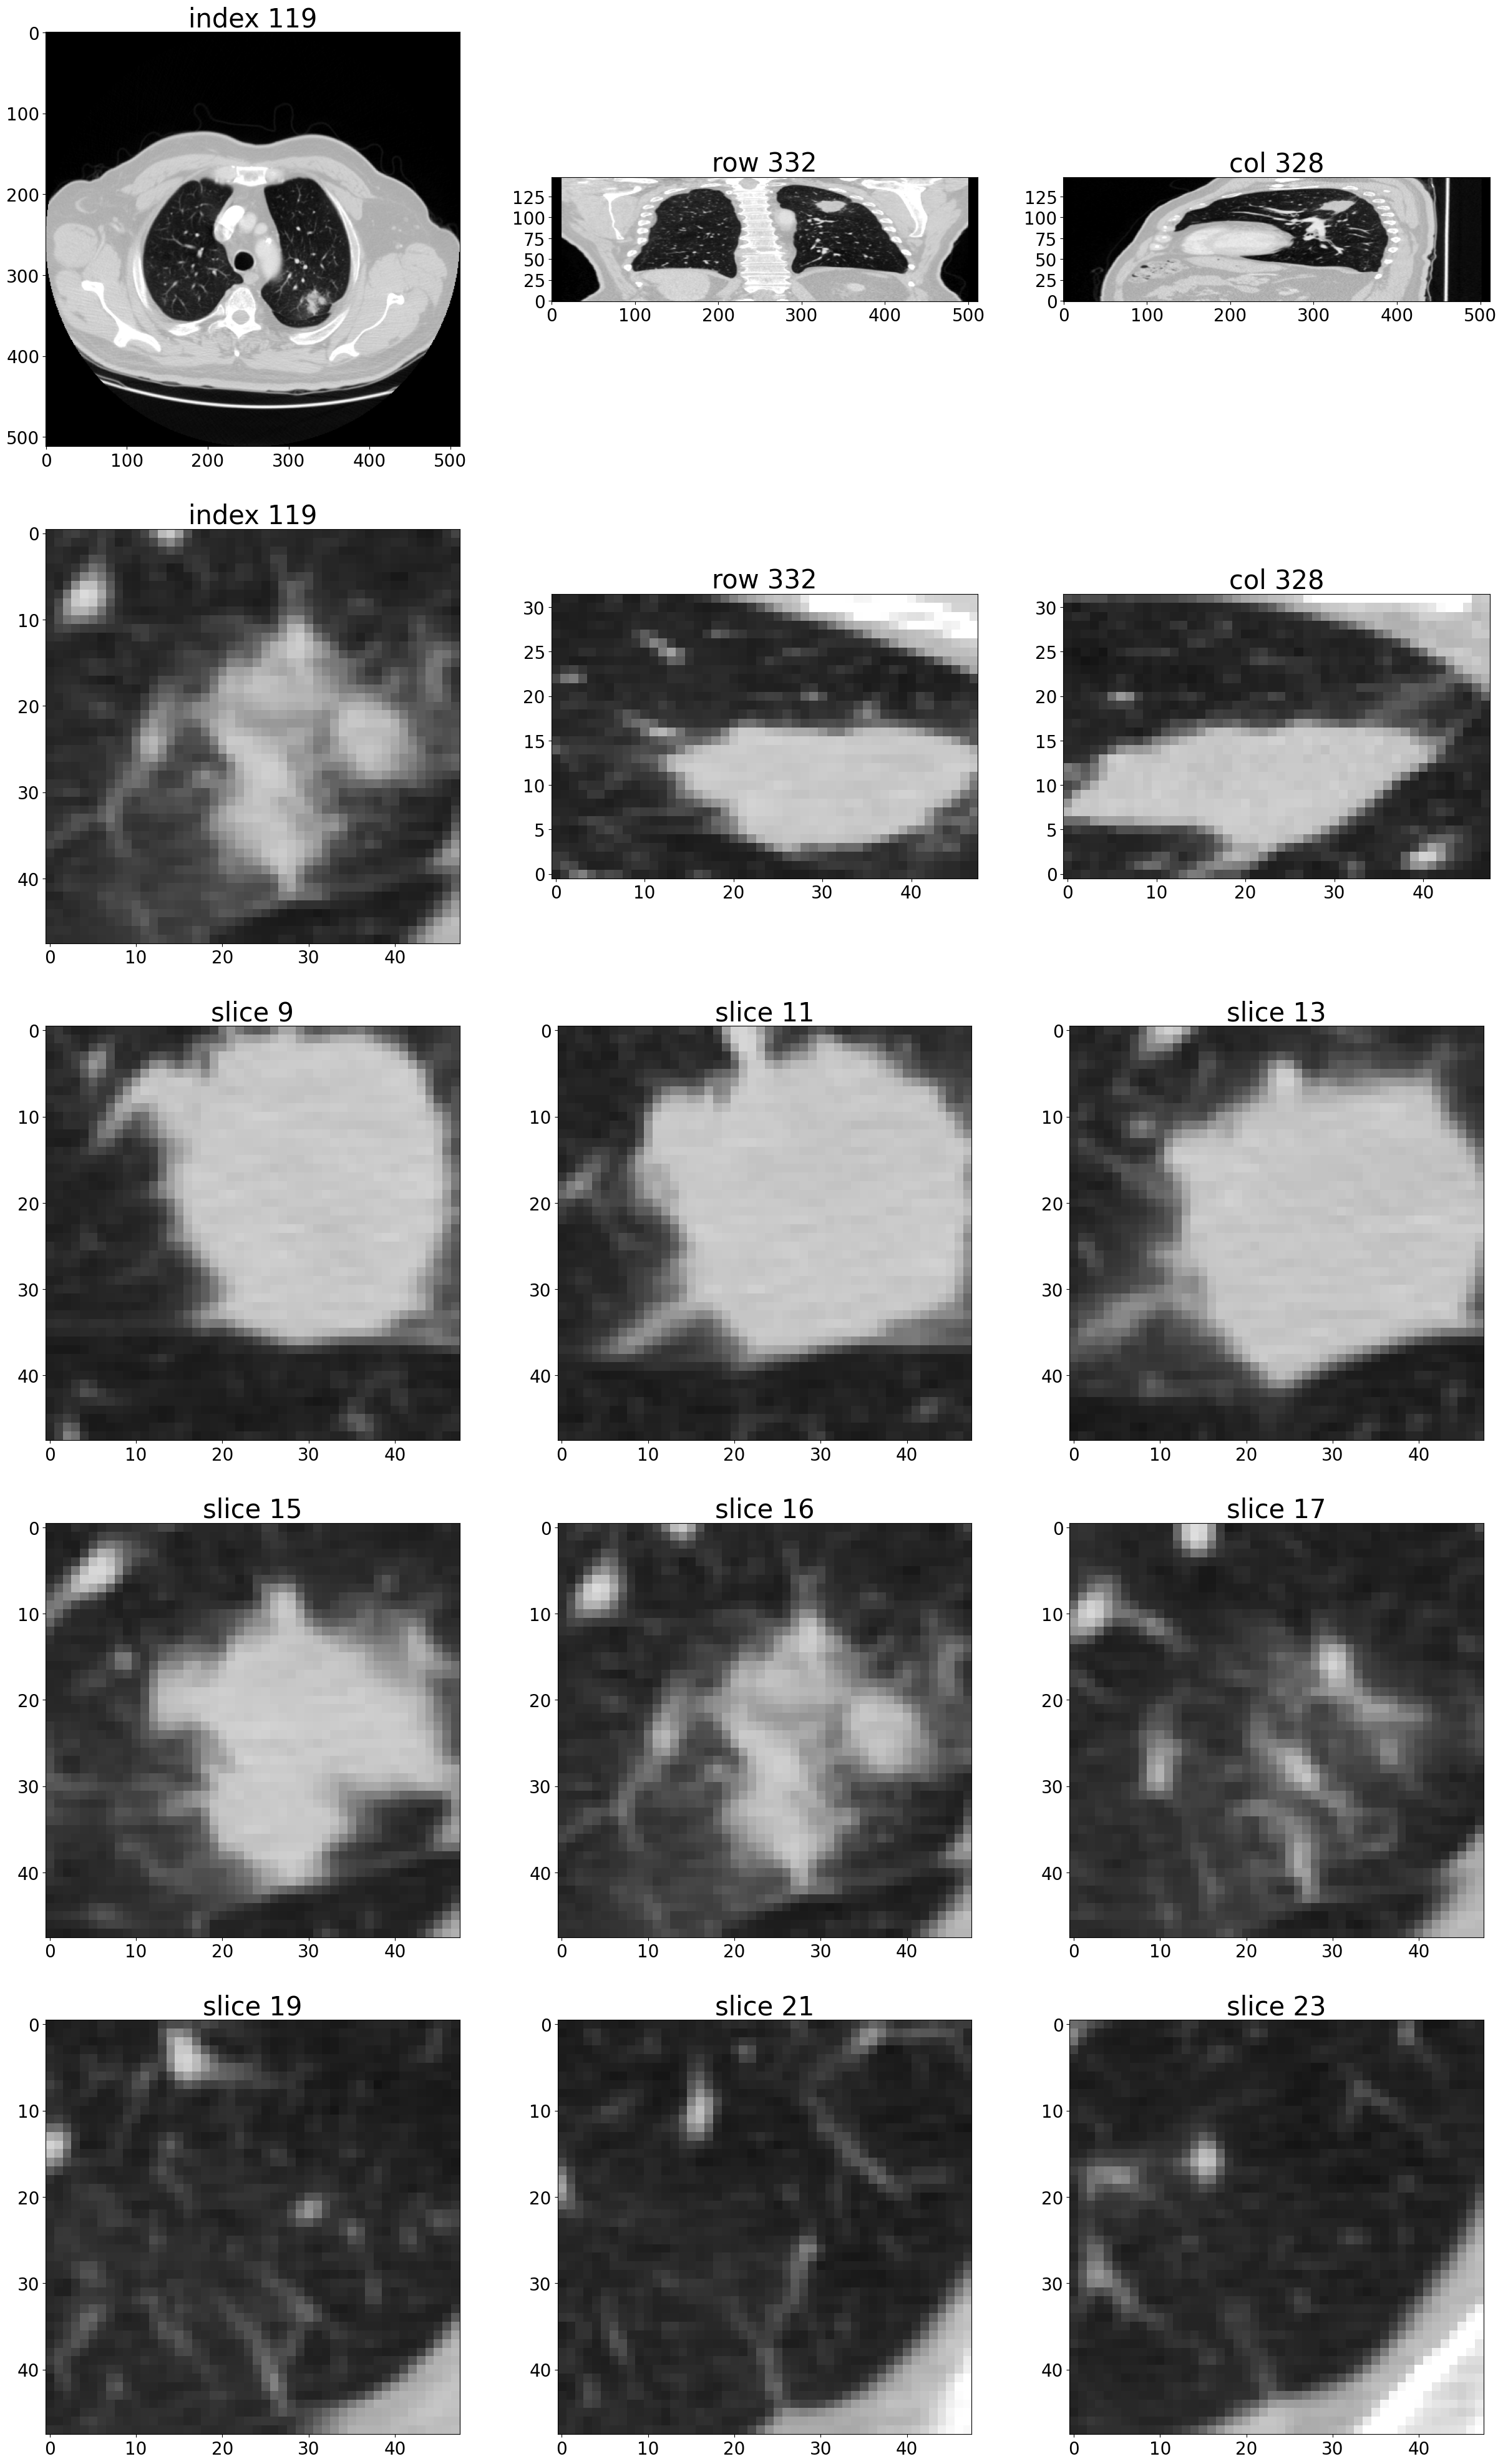

In [14]:
series_uid = positiveSample_list[1].series_uid
showCandidate(series_uid)

2025-05-26 11:52:24,045 INFO     pid:14824 p2ch12.dsets:266:__init__ <p2ch12.dsets.LunaDataset object at 0x00000157317951D0>: 911 training samples, 904 neg, 7 pos, unbalanced ratio


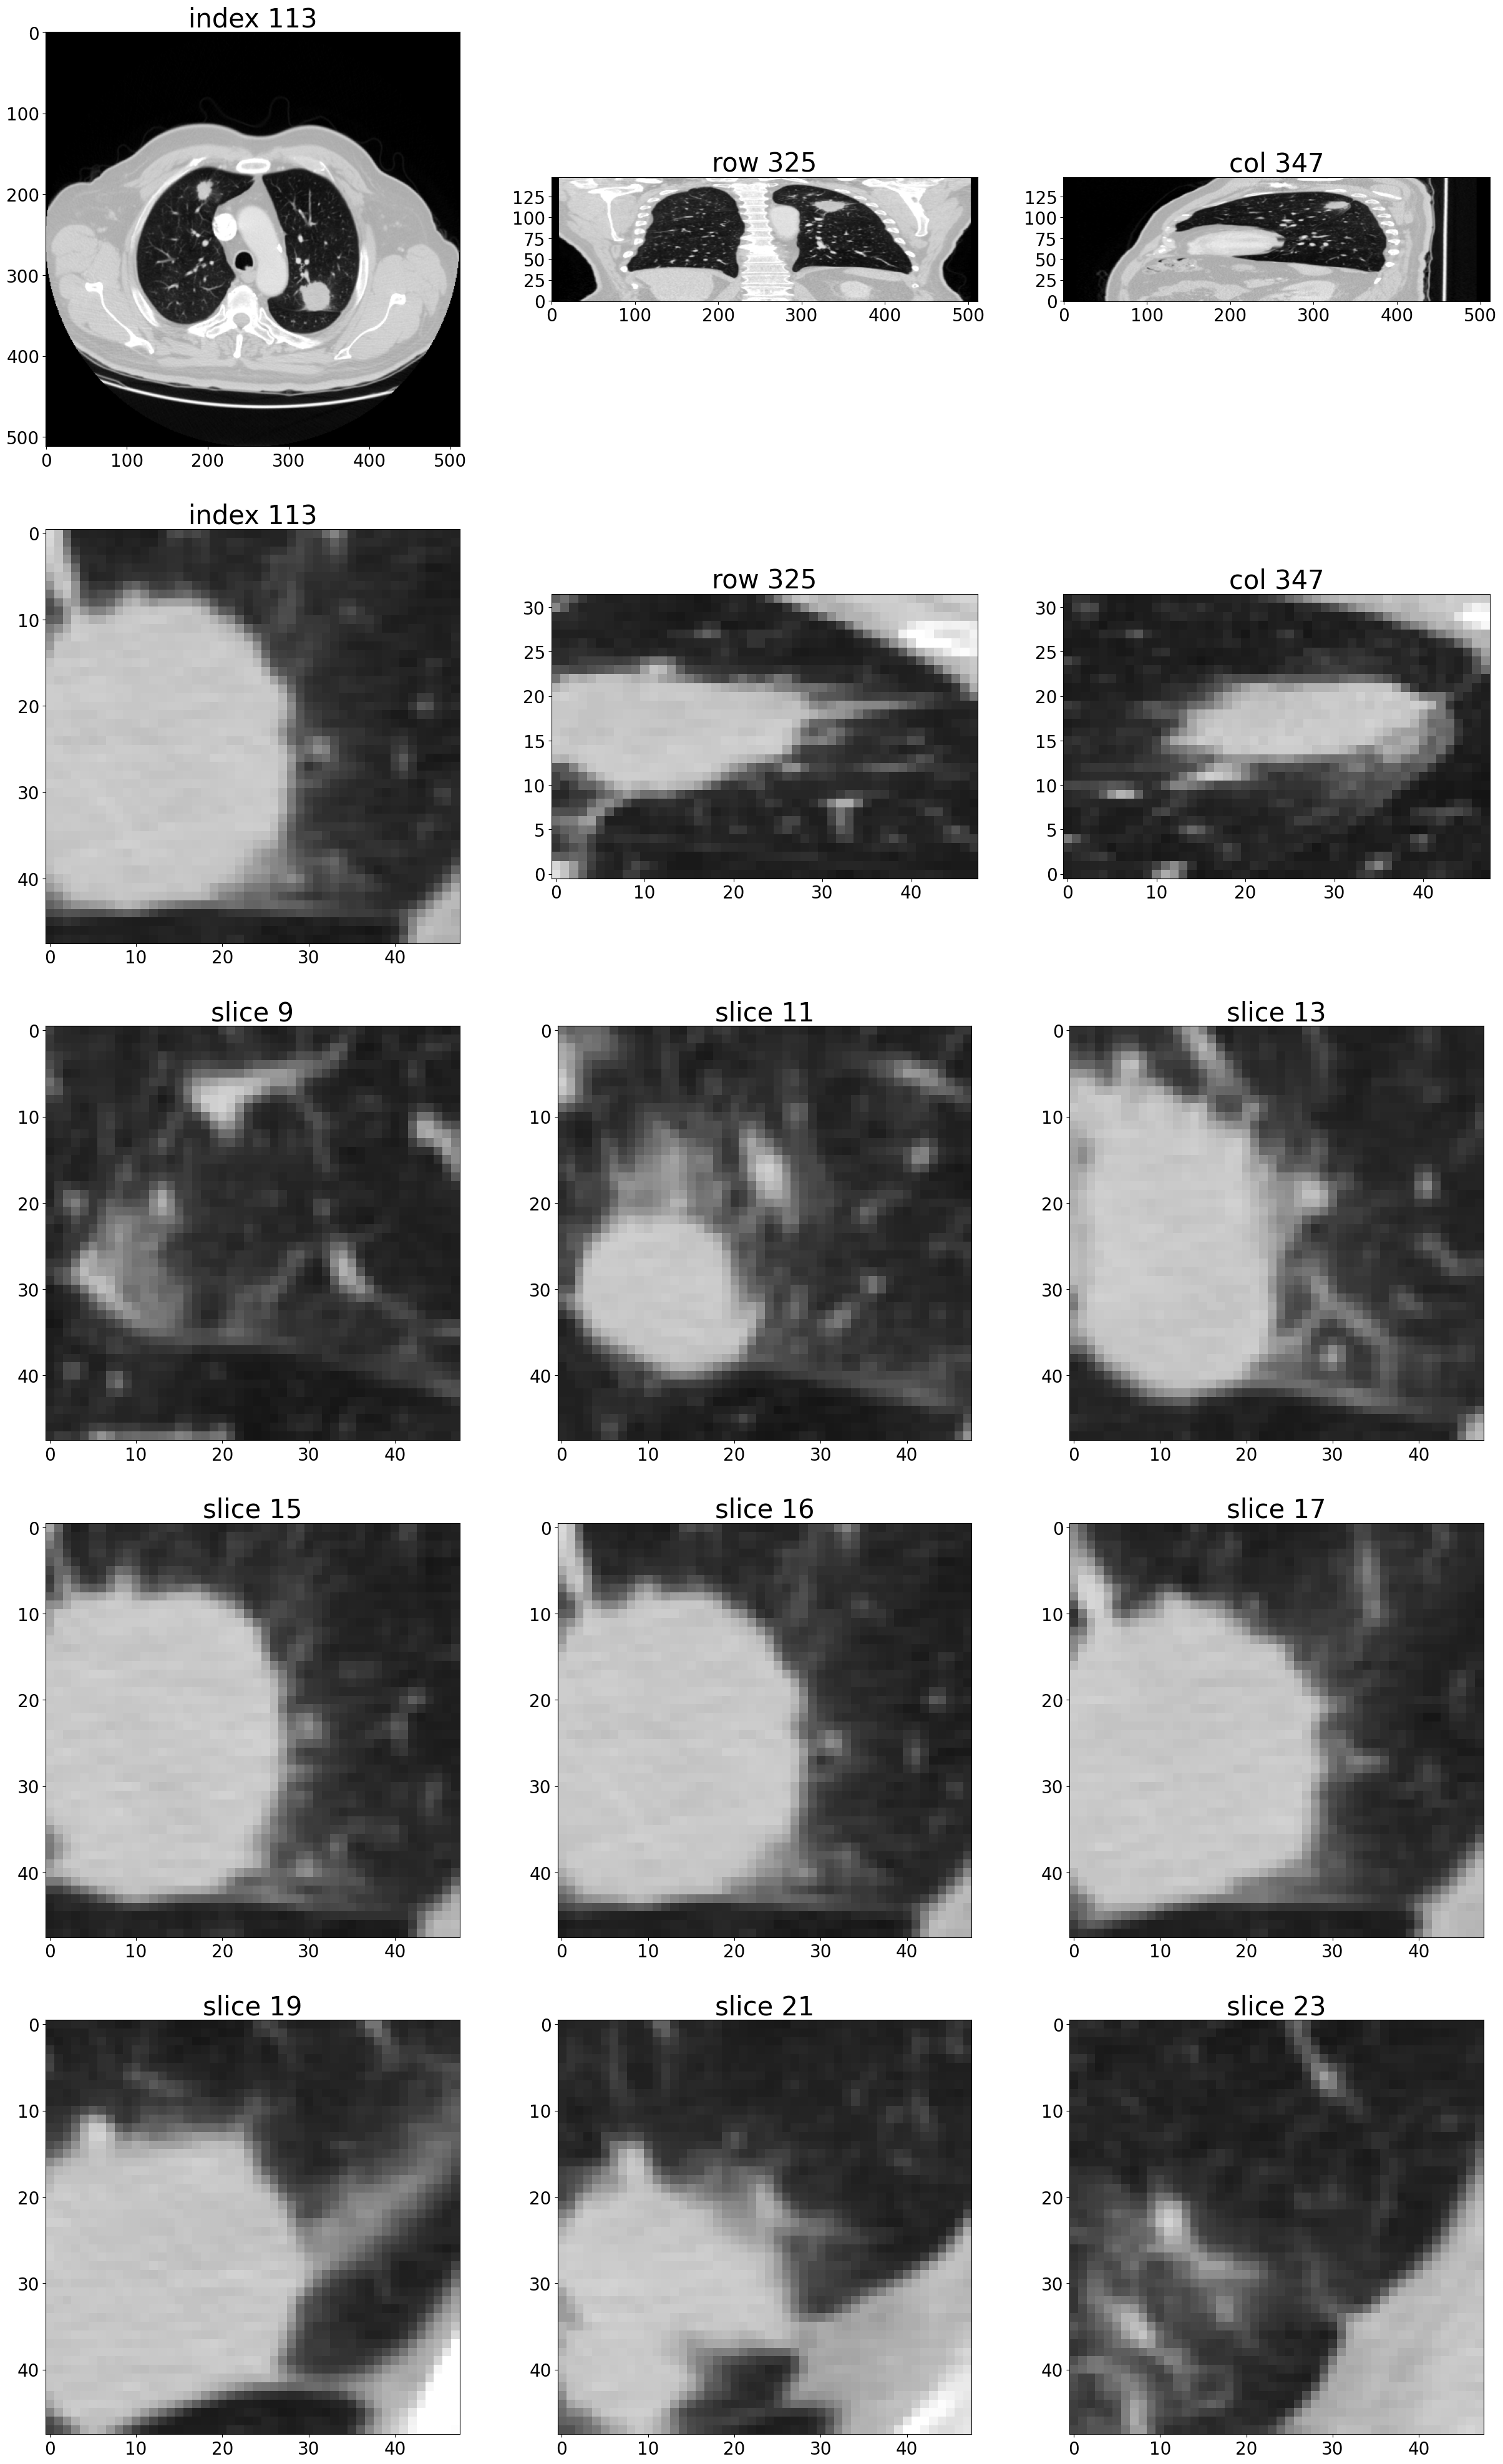

In [15]:
series_uid = positiveSample_list[1][2]
showCandidate(series_uid)